# Fooling Classifiers and Localization

In [1]:
#pip install matplotlib
#pip install torch
#pip install torchvision

In [2]:
import time
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from dataloader import VOCDetection, ToTensor, Rescale, Normalize, bb_intersection_over_union

%load_ext autoreload
%autoreload 2

## Part 1 - Fooling Classifers

In the previous exercise, we saw how to access the gradient information with respect to the **image** and create saliency maps. Saliency maps are a technique used to identify and highlight the regions of an input image that are most relevant to a model's prediction. This is achieved by computing the gradient of the output prediction with respect to the input image, which indicates how changes in pixel values could affect the prediction score.

We can also use this gradient information with respect to the image to fool classifiers.

Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

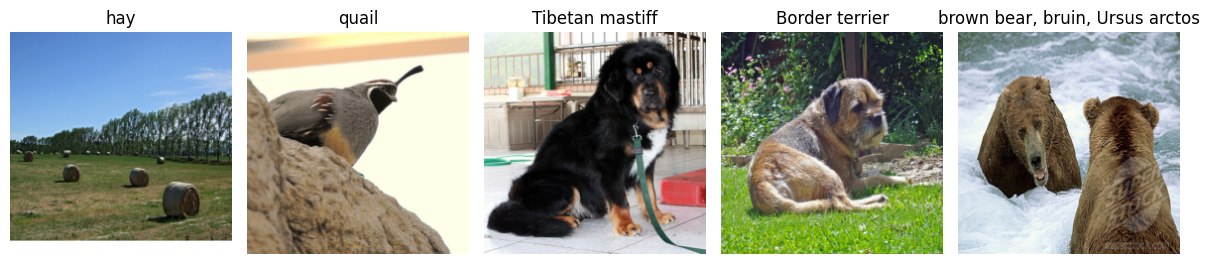

In [3]:
from imagenet_data.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Pretrained model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use [SqueezeNet](https://arxiv.org/abs/1602.07360), which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet, VGG or ResNet means that we can easily perform all image generation experiments on CPU.

In [4]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1

    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a "training" loop where you iteratively take the          #
    # normalized gradient and update the image. Dont forget to zero the grad.    # 
    #                                                                            #
    # For most examples, you should be able to generate a fooling image          #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################

    for i in range(100):
        scores = model(X_fooling)
        model.zero_grad()
        
        loss = nn.CrossEntropyLoss()(scores, torch.LongTensor([target_y]))
        loss.backward()

        grad = X_fooling.grad.data
        grad /= (grad.norm() + 1e-5)
        X_fooling.data -= learning_rate * grad
        X_fooling.data = torch.clamp(X_fooling.data, 0, 1) 
        X_fooling.grad.zero_()

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

In [6]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

Time to fool the classifier!

In [7]:
# Index of the image in the dataset to be fooled from the images loaded above
idx = 0
print(class_names[y[idx]])

hay


In [8]:
# The target class label that we want the model to incorrectly classify the modified image as
target_y = 809
class_names[target_y]

'soup bowl'

Note: sometimes you might need to run this more than once

In [9]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

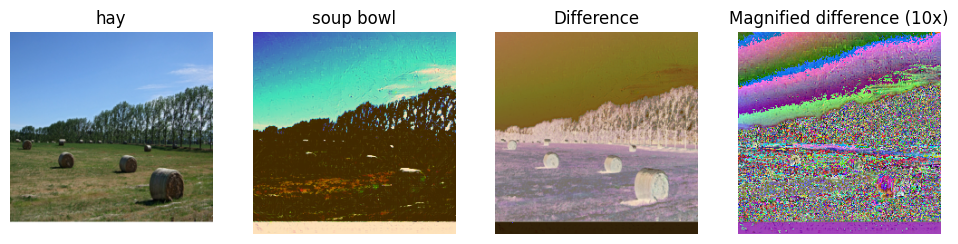

In [10]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

# Original image
plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

# Carefully noised image that fools the classifier
plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

### Theoretical questions:

1. Explain how minimal changes to an input image, imperceptible to the human eye, can lead to incorrect predictions by deep learning models.
1. Explain the implications of fooling images for the reliability of machine learning models in practical applications, especially in scenarios where accuracy is critical.
1. Can fooling images be easily detected by humans? Discuss whether the alterations made to create fooling images are typically noticeable to human observers and what this implies about the difference between human and machine vision in the context of image recognition.
1. How can saliency maps, which highlight the parts of the input most influential to the model's decision, be used to detect or even reverse-engineer fooling images?

#### Answers: 
1. Deep learning models are highly sensitive to even tiny changes in input, especially in critical areas for classification. Fooling images exploit this sensitivity by tweaking specific pixels related to a chosen class (like the soup bowl) to boost its probability while reducing others. Although these tweaks might seem minor to us, the model magnifies their impact, often exploiting subtle features or weaknesses in its decision-making process. Consequently, what appears as small adjustments to us can greatly alter the model's final prediction.
2. Fooling images highlight a significant vulnerability in machine learning models. They demonstrate that models can be misled by imperceptible alterations, which raises concerns about their reliability, especially in critical applications/in scenarios where accuracy is crucial, such as medical diagnosis or autonomous vehicles, the presence of fooling images can lead to catastrophic consequences if not addressed properly.
3. Fooling images are made to be hard for humans to spot, taking advantage of how machines see pictures. These small changes target weaknesses in machine learning models without changing what humans see. It shows the difference between how humans and machines look at images: humans see the whole picture and context, while machines focus on specific patterns or features that may not align with human perception, which makes them vulnerable to planned adjustments.
4. Saliency maps pinpoint the areas of the input image that have the greatest impact on the model's decision-making process. By identifying these influential regions, we can better grasp how such images deceive the model. Moreover, comparing these regions with the original image allows us to discern the alterations made to the image, aiding in the analysis of adversarial techniques.

## Part 2 - Localization as Regression

In the next part, we will use a well known architecture called `ResNet18` that was trained on ImageNet to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can create learn a model that can also localize cats and dogs using very few images.

In [12]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "animals"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [13]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

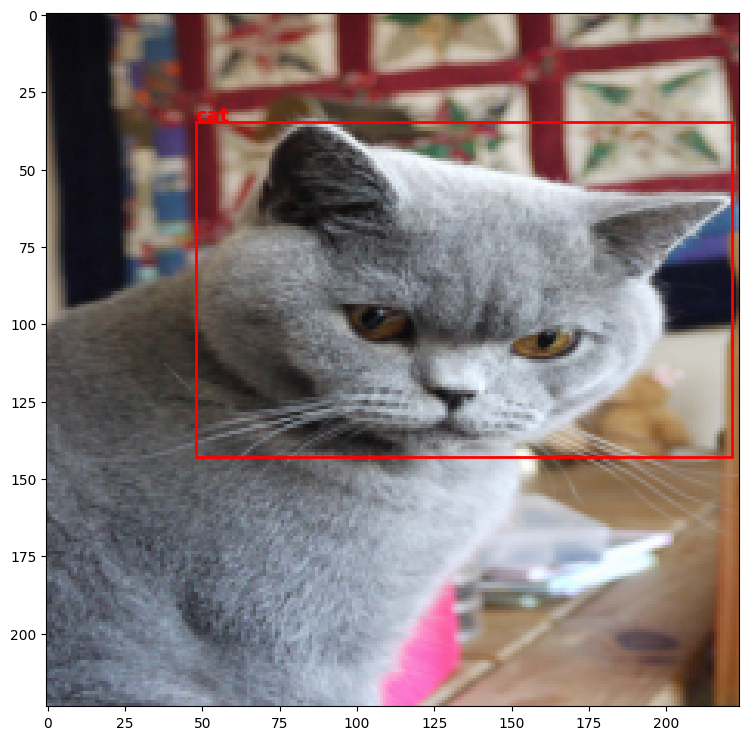

In [14]:
def imshow(img, label, bbox, classes, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Reverse normalization of image
    img = img[0].numpy()  # Convert to numpy if it's a tensor
    img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img = img * std + mean  # Apply reverse normalization
    img = np.clip(img, 0, 1)  # Ensure image range is [0, 1]

    # Extract and scale bounding box
    bbox = bbox[0].numpy()  # Convert to numpy if it's a tensor
    x1, y1, x2, y2 = bbox * 224  # Scale bbox assuming 224x224 image
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)

    # Plotting
    plt.figure(figsize=(12, 9))
    ax = plt.gca()
    ax.imshow(img)  # Display the image
    bbox_patch = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(bbox_patch)
    ax.annotate(classes[label[0]], (x1, y1), color='r', weight='bold', fontsize=14)
    plt.show()
    
imshow(sample['image'], sample['label'], sample['bbox'], classes)

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully           #
        # connected layer, so we could pass the features of the network and not the #
        # only the classification which carries significantly less information.     #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted dimensionality.                                                #
        # This function has no return value.                                        #
        #############################################################################
        self.model = models.resnet18(pretrained=True)
        
        # Freeze the pretrained layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Modify the fully connected layer to output a generic feature vector
        num_features = self.model.fc.in_features  # Get the number of input features of the last layer
        
        # Replace the fully connected layer with a new one that outputs a 400-dimensional feature vector
        self.model.fc = nn.Linear(num_features, 1000)
        
        # Add separate fully connected layers for classification and bounding box prediction
        self.out_class = nn.Linear(1000, num_classes)
        self.out_box = nn.Linear(1000, 4)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns class predications and bounding boxes.              #
        #############################################################################

        output = self.model(images)

        class_predications = self.out_class(output)
        
        bounding_boxes = self.out_box(output)
        
        return class_predications, bounding_boxes
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [16]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # improve during training.                                                  #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                
                images = sample['image']
                labels = sample['label']
                bboxs = sample['bbox']

                optimizer.zero_grad()
    
                class_predications, bbox_pred = model.forward(images)
                # Calculate classification loss
                class_pred = torch.sigmoid(class_predications)

                # classification
                preds = (class_pred >= 0.5).float()
                labels = labels.unsqueeze(1).float()
                loss_cls = criterion_cls(class_pred, labels)

                # Calculate bounding box regression loss
                loss_bbox = criterion_bbox(bbox_pred, bboxs)

                # Combine the losses
                loss = loss_cls + loss_bbox
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                for bb, bb_pred in zip(bboxs, bbox_pred):
                    iou += bb_intersection_over_union(bb, bb_pred)
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
import torch.optim as optim

cnn = CNN(1) # binary classification problem.
cnn = cnn.to(device)

criterion_cls = nn.BCELoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.9286  |  Acc: 0.9151  |  IOU: 0.3389
val Loss: 0.0977  |  Acc: 0.9873  |  IOU: 0.5597
Epoch 1/4
----------
train Loss: 0.1616  |  Acc: 0.9528  |  IOU: 0.6728
val Loss: 0.1258  |  Acc: 0.9810  |  IOU: 0.6213
Epoch 2/4
----------
train Loss: 0.1466  |  Acc: 0.9560  |  IOU: 0.6659
val Loss: 0.0510  |  Acc: 0.9810  |  IOU: 0.7012
Epoch 3/4
----------
train Loss: 0.0925  |  Acc: 0.9811  |  IOU: 0.7086
val Loss: 0.0588  |  Acc: 0.9937  |  IOU: 0.6763
Epoch 4/4
----------
train Loss: 0.0489  |  Acc: 0.9937  |  IOU: 0.7090
val Loss: 0.0768  |  Acc: 0.9873  |  IOU: 0.5881
Training complete in 6m 21s
Best val Acc: 0.993671


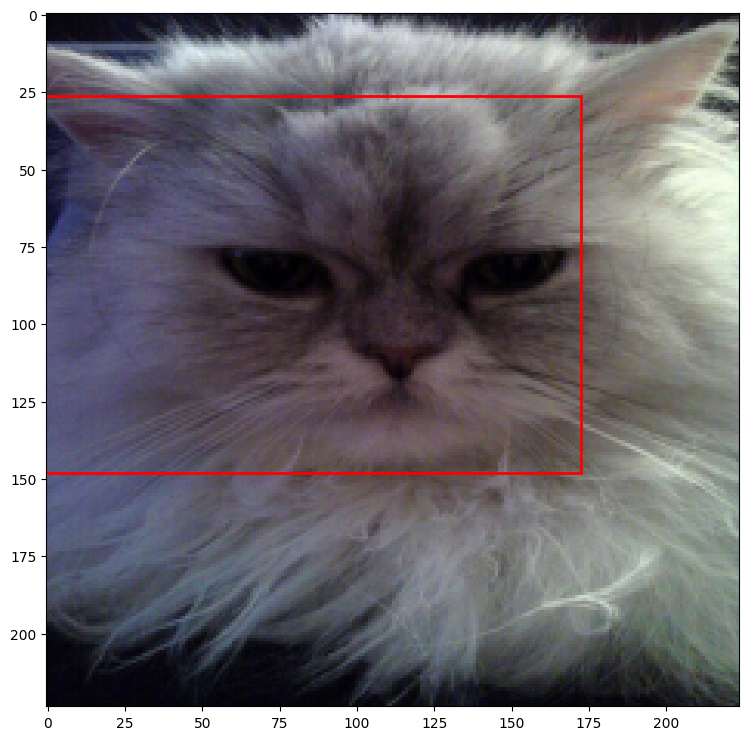

In [19]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    sigmoid = torch.sigmoid(label_pred.squeeze())  # sigmoid to convert logits to probabilities
    preds = sigmoid > 0.5  # threshold to determine class labels
    preds = preds.long()  # convert boolean labels to long if needed
imshow(sample['image'], preds.cpu(), bbox_pred.cpu(), classes)

### Theoretical questions:

1. Why do we need to set the model to training or evaluation modes using `model.train()` and `model.eval()`?
1. How do you measure the accuracy of a localization model? Describe the metrics or methods used to evaluate the performance of a model in correctly identifying the positions of objects.
1. Discuss how IoU is calculated and why it is a critical metric for assessing the accuracy of bounding box predictions in object localization tasks.
1. How would you improve the performance of this model?

#### Answers:
1. In training mode (model.train()), the network enables layers like dropout to prevent overfitting by introducing randomness, and batch normalization layers to use current batch statistics. In evaluation mode (model.eval()), these behaviors are disabled to ensure consistency and determinism in the predictions, as we want to assess the model's performance on unseen data without the random influences present during training.
2. The accuracy of a localization model is typically measured using IoU and average precision (average precision that i learned from the chat). IoU calculates how much the predicted bounding box overlaps with the ground truth bounding box. A higher IoU means better localization accuracy. Average precision may take into account multiple IoU thresholds to determine the precision of the model at each threshold.
3. Intersection over Union (IoU) is calculated by dividing the area of the intersection of the predicted bounding box with the ground truth bounding box by the area of their union. Mathematically, it's IoU = Area of Overlap / Area of Union. It's a critical metric because it quantifies the quality of the object localization independently of the class prediction, allowing us to understand how well the model is doing in terms of spatial localization.
4. A few ways:
* Advanced Architectures: Use anthoer architectures.
* Hyperparameter Optimization: Experiment with different learning rates, batch sizes, change the num of epoch and optimizers to find the best set of parameters.
#I learned from the chat- 
* Data Augmentation: Introduce more variety in the training data through techniques such as random cropping, rotations, and color jittering to make the model more robust.
* Loss Function Tweaking: Use a different balance between the classification and bounding box regression losses, or employ more sophisticated loss functions such as the Focal loss for classification or IoU-based loss for localization.

And more....





In [20]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0588  |  Acc: 0.9874  |  IOU: 0.6846
val Loss: 0.0591  |  Acc: 0.9873  |  IOU: 0.6372
Epoch 1/9
----------
train Loss: 0.0990  |  Acc: 0.9764  |  IOU: 0.7011
val Loss: 0.0635  |  Acc: 0.9873  |  IOU: 0.6655
Epoch 2/9
----------
train Loss: 0.1538  |  Acc: 0.9481  |  IOU: 0.7089
val Loss: 0.1595  |  Acc: 0.9557  |  IOU: 0.6564
Epoch 3/9
----------
train Loss: 0.1691  |  Acc: 0.9497  |  IOU: 0.6985
val Loss: 0.0712  |  Acc: 0.9810  |  IOU: 0.6791
Epoch 4/9
----------
train Loss: 0.1120  |  Acc: 0.9670  |  IOU: 0.6931
val Loss: 0.0831  |  Acc: 0.9810  |  IOU: 0.6970
Epoch 5/9
----------
train Loss: 0.0422  |  Acc: 0.9921  |  IOU: 0.7307
val Loss: 0.0523  |  Acc: 0.9937  |  IOU: 0.6502
Epoch 6/9
----------
train Loss: 0.0723  |  Acc: 0.9811  |  IOU: 0.7230
val Loss: 0.0446  |  Acc: 0.9873  |  IOU: 0.7072
Epoch 7/9
----------
train Loss: 0.0681  |  Acc: 0.9796  |  IOU: 0.7305
val Loss: 0.0508  |  Acc: 0.9937  |  IOU: 0.6923
Epoch 8/9
----------
train Loss:

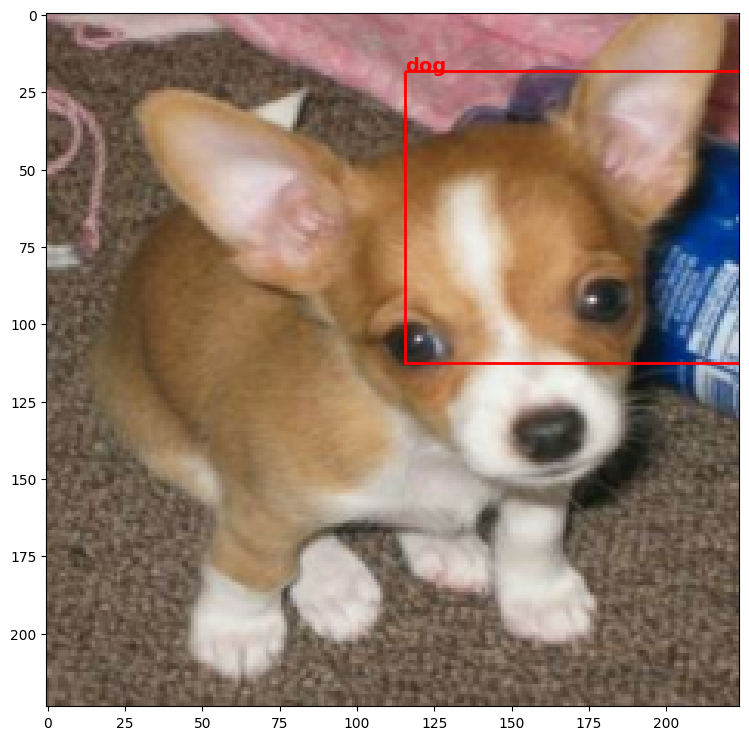

In [22]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    sigmoid = torch.sigmoid(label_pred.squeeze())  # sigmoid to convert logits to probabilities
    preds = sigmoid > 0.5  # threshold to determine class labels
    preds = preds.long()  # convert boolean labels to long if needed
imshow(sample['image'], preds.cpu(), bbox_pred.cpu(), classes)